# Cohort Retention Analysis - Olist E-Commerce

**Project:** QuintoAndar Case Study - Olist E-Commerce Analysis  
**Notebook:** 03 - Cohort Retention Analysis  
**Author:** Andre Bomfim  
**Date:** 2024-12-10  
**Last Updated:** 2024-12-18

## Objectives:
1. Analyze customer retention patterns by cohort
2. Identify best and worst performing cohorts
3. Calculate retention decay and drop-off rates
4. Measure revenue retention over time
5. Provide actionable recommendations to improve retention
6. Export visualizations for presentation

In [14]:
import sys
import subprocess

try:
    import kaleido
    print("kaleido is already installed")
except ImportError:
    print("kaleido is not installed. Installing now...")
    
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaleido"])
    
    print("kaleido installed successfully!")
    print("restart kernel")

kaleido is not installed. Installing now...
kaleido installed successfully!
restart kernel


## 1. IMPORTS AND LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os


## 2. BIGQUERY CONFIGURATION

In [3]:
PROJECT_ID = 'quintoandar-ecommerce-analysis'
KEY_PATH = 'C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json'

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

try:
    from google.cloud import bigquery
    from google.oauth2 import service_account
    
    credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
    client = bigquery.Client(project=PROJECT_ID, credentials=credentials)
    
    print(f"BigQuery connected successfully to project: {PROJECT_ID}")
    BIGQUERY_AVAILABLE = True
    
except Exception as e:
    print(f"Error connecting to BigQuery: {e}")
    print("Will use simulated data for demonstration")
    BIGQUERY_AVAILABLE = False

print(f"Execution date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

BigQuery connected successfully to project: quintoandar-ecommerce-analysis
Execution date: 2025-12-18 15:37:12


## 3. SQL QUERIES FOR DATA EXTRACTION

In [4]:
if BIGQUERY_AVAILABLE:
    cohort_query = f"""
    SELECT *
    FROM `{PROJECT_ID}.olist_marts.mart_customer_cohort_retention`
    ORDER BY cohort_month, months_since_first_purchase
    """
    
    try:
        df_cohort = client.query(cohort_query).to_dataframe()
        print("Data loaded successfully from BigQuery")
        print(f"Dataset shape: {df_cohort.shape}")
        print("\nPrimeiras linhas do dataset:")
        print(df_cohort.head())
        
        # Validação das colunas
        print("\nColunas disponíveis:")
        for col in df_cohort.columns:
            print(f"- {col}")
            
    except Exception as e:
        print(f"Error executing BigQuery: {e}")
        BIGQUERY_AVAILABLE = False
        print("Falling back to sample data...")

if not BIGQUERY_AVAILABLE:

    np.random.seed(42)
    
    months = pd.date_range('2023-01-01', '2024-06-01', freq='MS')
    data = []
    
    for i, cohort_month in enumerate(months):
        cohort_size = np.random.randint(800, 1500)
        
        for months_since in range(0, 13):
            if i + months_since < len(months):
                retention_rate = max(0.05, 0.7 * np.exp(-0.3 * months_since) + np.random.normal(0, 0.05))
                retention_rate = min(1.0, max(0.0, retention_rate))
                
                data.append({
                    'cohort_month': cohort_month.strftime('%Y-%m'),
                    'cohort_start_date': cohort_month,
                    'months_since_first_purchase': months_since,
                    'month_label': f'M{months_since}',
                    'cohort_size': cohort_size if months_since == 0 else 0,
                    'retained_customers': cohort_size * retention_rate,
                    'retention_rate': retention_rate,
                    'cohort_revenue': cohort_size * retention_rate * np.random.uniform(50, 200),
                    'cumulative_revenue': cohort_size * retention_rate * np.random.uniform(100, 300) * (months_since + 1),
                    'avg_revenue_per_order': np.random.uniform(80, 150),
                    'revenue_per_customer': np.random.uniform(100, 250)
                })
    
    df_cohort = pd.DataFrame(data)
    
    for cohort in df_cohort['cohort_month'].unique():
        cohort_size = df_cohort[(df_cohort['cohort_month'] == cohort) & 
                                (df_cohort['months_since_first_purchase'] == 0)]['cohort_size'].values[0]
        df_cohort.loc[df_cohort['cohort_month'] == cohort, 'cohort_size'] = cohort_size
    
    print("Created sample cohort data (simulating mart_customer_cohort_retention)")
    print(f"Dataset shape: {df_cohort.shape}")
    print("\nColumns in the simulated dataset:")
    print(df_cohort.columns.tolist())

Data loaded successfully from BigQuery
Dataset shape: (23, 11)

Primeiras linhas do dataset:
  cohort_month         cohort_start_date  cohort_size  \
0      2016-09 2016-09-15 12:16:38+00:00            1   
1      2016-10 2016-10-03 09:44:50+00:00          279   
2      2016-12 2016-12-23 23:16:47+00:00            1   
3      2017-01 2017-01-05 11:56:06+00:00          761   
4      2017-02 2017-02-01 08:42:43+00:00         1661   

   months_since_first_purchase month_label  retained_customers  \
0                            0          M0                   1   
1                            0          M0                 279   
2                            0          M0                   1   
3                            0          M0                 761   
4                            0          M0                1661   

   retention_rate  cohort_revenue  cumulative_revenue  avg_revenue_per_order  \
0          100.00             NaN                 NaN                    NaN   
1      

## 4. COHORT OVERVIEW

Directory created/verified: presentation/figures
COHORT OVERVIEW:
Total unique cohorts: 23
Total customers: 95,419
Analysis period: 2016-09 to 2018-08
Average cohort size: 4149 customers


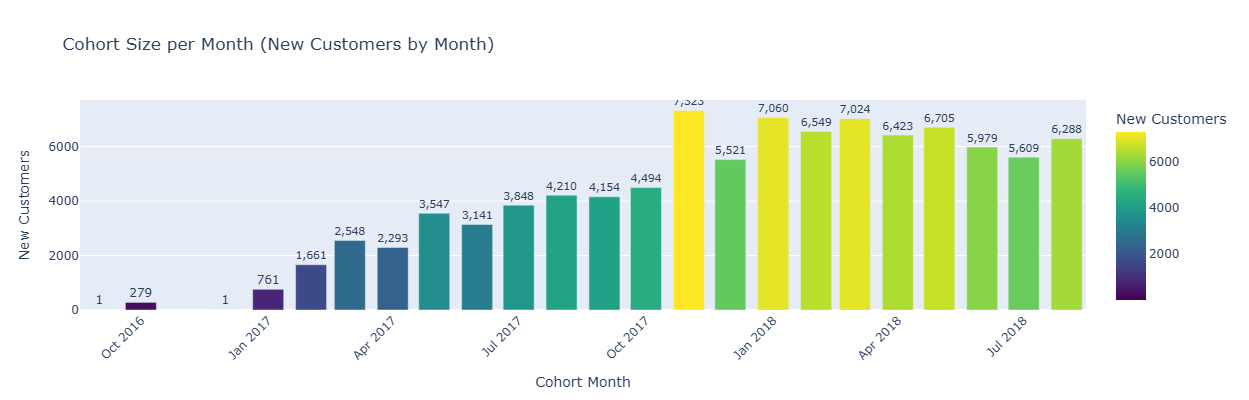

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [ ]:
if len(df_cohort) > 0:

    import os
    
    figures_dir = "presentation/figures"
    os.makedirs(figures_dir, exist_ok=True)
    print(f"Directory created/verified: {figures_dir}")
    
    df_cohort_m0 = df_cohort[df_cohort['months_since_first_purchase'] == 0]
    
    if len(df_cohort_m0) > 0:
        total_cohorts = df_cohort_m0.shape[0]
        total_customers = df_cohort_m0['cohort_size'].sum()
        avg_cohort_size = df_cohort_m0['cohort_size'].mean()
        
        print("COHORT OVERVIEW:")
        print("="*60)
        print(f"Total unique cohorts: {total_cohorts}")
        print(f"Total customers: {total_customers:,}")
        print(f"Analysis period: {df_cohort['cohort_month'].min()} to {df_cohort['cohort_month'].max()}")
        print(f"Average cohort size: {avg_cohort_size:.0f} customers")
        
        fig = px.bar(
            df_cohort_m0.sort_values('cohort_month'),
            x='cohort_month',
            y='cohort_size',
            title='Cohort Size per Month (New Customers by Month)',
            labels={'cohort_month': 'Cohort Month', 'cohort_size': 'New Customers'},
            text='cohort_size',
            color='cohort_size',
            color_continuous_scale='Viridis'
        )
        
        fig.update_traces(texttemplate='%{text:,}', textposition='outside')
        fig.update_layout(xaxis_tickangle=-45, showlegend=False, height=400)
        fig.show()
        
        fig.write_image("presentation/figures/cohort_size_monthly.png", scale=2)
        print("Saved: presentation/figures/cohort_size_monthly.png")
        
else:
    print("WARNING: Empty DataFrame.")

## 5. RETENTION HEATMAP

Retention Matrix: 23 cohorts x 1 months


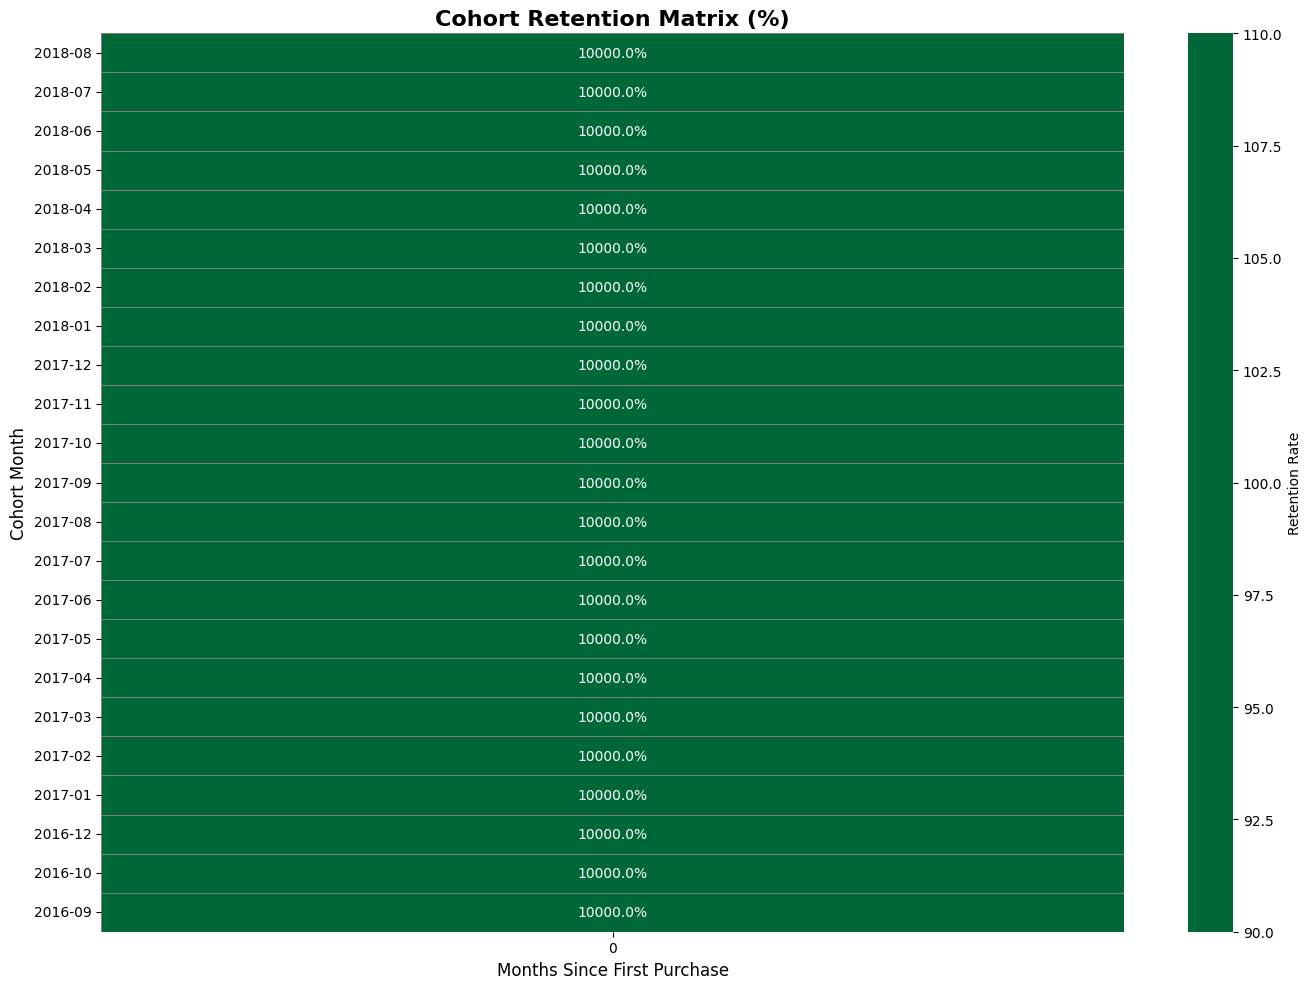

Saved: presentation/figures\cohort_retention_heatmap.png


In [18]:
if len(df_cohort) > 0:
    import os
    
    figures_dir = "presentation/figures"
    os.makedirs(figures_dir, exist_ok=True)
    
    max_months_available = min(12, df_cohort['months_since_first_purchase'].max())
    df_cohort_filtered = df_cohort[df_cohort['months_since_first_purchase'] <= max_months_available]
    
    retention_pivot = df_cohort_filtered.pivot_table(
        index='cohort_month',
        columns='months_since_first_purchase',
        values='retention_rate',
        aggfunc='first'
    )
    
    retention_pivot = retention_pivot.sort_index(ascending=False)
    
    print(f"Retention Matrix: {retention_pivot.shape[0]} cohorts x {retention_pivot.shape[1]} months")
    
    plt.figure(figsize=(14, 10))
    
    ax = sns.heatmap(
        retention_pivot,
        annot=True,
        fmt='.1%',
        cmap='RdYlGn',
        center=0.5,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Retention Rate'}
    )
    
    plt.title('Cohort Retention Matrix (%)', fontsize=16, fontweight='bold')
    plt.xlabel('Months Since First Purchase', fontsize=12)
    plt.ylabel('Cohort Month', fontsize=12)
    plt.tight_layout()
    
    filepath = os.path.join(figures_dir, "cohort_retention_heatmap.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filepath}")
    
    if 3 in retention_pivot.columns:
        avg_m3_retention = retention_pivot[3].mean() * 100
        best_m3_cohort = retention_pivot[3].idxmax()
        best_m3_value = retention_pivot[3].max() * 100
        worst_m3_cohort = retention_pivot[3].idxmin()
        worst_m3_value = retention_pivot[3].min() * 100
        
        print(f"\nM3 Retention Analysis:")
        print(f"Average M3 retention: {avg_m3_retention:.2f}%")
        print(f"Best cohort: {best_m3_cohort} with {best_m3_value:.2f}%")
        print(f"Worst cohort: {worst_m3_cohort} with {worst_m3_value:.2f}%")
        print(f"Variation: {best_m3_value - worst_m3_value:.2f} percentage points")
        
else:
    print("WARNING: Empty DataFrame") #ok

## 6. RETENTION CURVES

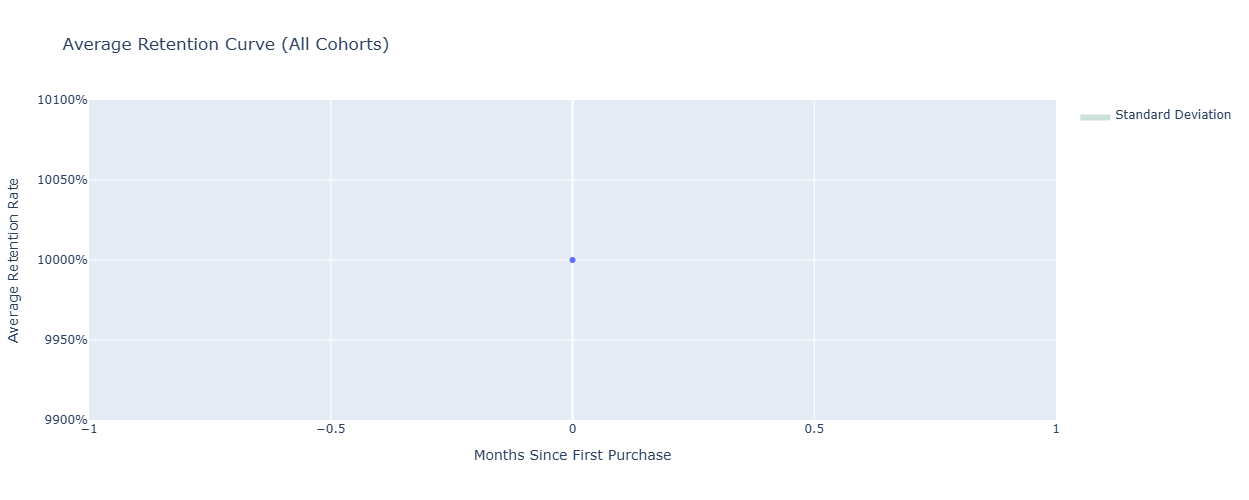

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [7]:
if len(df_cohort) > 0:
    avg_retention_curve = df_cohort.groupby('months_since_first_purchase')['retention_rate'].agg(['mean', 'std', 'count']).reset_index()
    avg_retention_curve.columns = ['months_since_first_purchase', 'avg_retention_rate', 'std_retention_rate', 'cohort_count']
    avg_retention_curve = avg_retention_curve[avg_retention_curve['cohort_count'] >= 3]
    
    fig = px.line(
        avg_retention_curve,
        x='months_since_first_purchase',
        y='avg_retention_rate',
        title='Average Retention Curve (All Cohorts)',
        labels={'months_since_first_purchase': 'Months Since First Purchase', 
                'avg_retention_rate': 'Average Retention Rate'},
        markers=True
    )
    
    fig.add_trace(go.Scatter(
        x=pd.concat([avg_retention_curve['months_since_first_purchase'], 
                     avg_retention_curve['months_since_first_purchase'][::-1]]),
        y=pd.concat([avg_retention_curve['avg_retention_rate'] + avg_retention_curve['std_retention_rate'], 
                     (avg_retention_curve['avg_retention_rate'] - avg_retention_curve['std_retention_rate'])[::-1]]),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='Standard Deviation'
    ))
    
    fig.update_layout(height=500, yaxis_tickformat='.0%', hovermode='x')
    fig.show()
    
    fig.write_image("presentation/figures/retention_curve_average.png", scale=2)
    print("Saved: presentation/figures/retention_curve_average.png")
    
    df_cohort_m0 = df_cohort[df_cohort['months_since_first_purchase'] == 0]
    
    if len(df_cohort_m0) > 0:
        top_cohorts = df_cohort_m0.sort_values('cohort_month', ascending=False).head(7)['cohort_month'].tolist()
        df_top_cohorts = df_cohort[df_cohort['cohort_month'].isin(top_cohorts)]
        
        fig = px.line(
            df_top_cohorts,
            x='months_since_first_purchase',
            y='retention_rate',
            color='cohort_month',
            title='Retention Curves - Top 7 Recent Cohorts',
            labels={'months_since_first_purchase': 'Months Since First Purchase', 
                    'retention_rate': 'Retention Rate',
                    'cohort_month': 'Cohort'},
            markers=True
        )
        
        fig.update_layout(height=500, yaxis_tickformat='.0%', hovermode='x')
        fig.show()
        
        fig.write_image("presentation/figures/retention_curves_recent.png", scale=2)
        print("Saved: presentation/figures/retention_curves_recent.png")
        
    if len(avg_retention_curve) >= 6:
        m1_data = avg_retention_curve[avg_retention_curve['months_since_first_purchase'] == 1]
        m3_data = avg_retention_curve[avg_retention_curve['months_since_first_purchase'] == 3]
        m6_data = avg_retention_curve[avg_retention_curve['months_since_first_purchase'] == 6]
        
        if len(m1_data) > 0 and len(m3_data) > 0:
            m1_rate = m1_data['avg_retention_rate'].iloc[0]
            m3_rate = m3_data['avg_retention_rate'].iloc[0]
            decay_m1_m3 = ((m3_rate - m1_rate) / m1_rate) * 100 if m1_rate > 0 else 0
            print(f"Retention decay from M1 to M3: {decay_m1_m3:.1f}%")
            
else:
    print("WARNING: Empty DataFrame.")

## 7. DROP-OFF ANALYSIS

In [8]:
if len(df_cohort) > 0:
    import os
    
    figures_dir = "presentation/figures"
    os.makedirs(figures_dir, exist_ok=True)
    
    dropoff_analysis = []
    
    for cohort in df_cohort['cohort_month'].unique():
        cohort_data = df_cohort[df_cohort['cohort_month'] == cohort].sort_values('months_since_first_purchase')
        
        if len(cohort_data) > 1:
            cohort_data = cohort_data.copy()
            cohort_data['retention_change'] = cohort_data['retention_rate'].diff()
            
            if not cohort_data['retention_change'].isnull().all():
                drop_indices = cohort_data['retention_change'] < 0
                if drop_indices.any():
                    max_drop_idx = cohort_data.loc[drop_indices, 'retention_change'].idxmin()
                    max_drop_month = cohort_data.loc[max_drop_idx, 'months_since_first_purchase']
                    max_drop_value = cohort_data.loc[max_drop_idx, 'retention_change']
                    
                    cohort_size_data = cohort_data[cohort_data['months_since_first_purchase'] == 0]['cohort_size']
                    initial_size = cohort_size_data.iloc[0] if len(cohort_size_data) > 0 else 0
                    
                    dropoff_analysis.append({
                        'cohort_month': cohort,
                        'max_drop_month': max_drop_month,
                        'max_drop_value': max_drop_value,
                        'initial_size': initial_size
                    })
    
    if dropoff_analysis:
        dropoff_df = pd.DataFrame(dropoff_analysis)
        dropoff_by_month = dropoff_df.groupby('max_drop_month').agg(
            cohort_count=('cohort_month', 'count'),
            avg_drop_value=('max_drop_value', 'mean'),
            total_customers_affected=('initial_size', 'sum')
        ).reset_index()
        
        dropoff_by_month['avg_drop_value_pct'] = dropoff_by_month['avg_drop_value'].abs()
        
        fig = px.bar(
            dropoff_by_month,
            x='max_drop_month',
            y='avg_drop_value_pct',
            title='Average Drop-off by Period (Retention Loss)',
            labels={'max_drop_month': 'Month of Drop-off', 
                    'avg_drop_value_pct': 'Average Retention Drop',
                    'cohort_count': 'Number of Cohorts'},
            text='cohort_count',
            color='avg_drop_value_pct',
            color_continuous_scale='Reds'
        )
        
        fig.update_traces(texttemplate='%{text} cohorts', textposition='outside')
        fig.update_layout(height=500, yaxis_tickformat='.0%', showlegend=False)
        fig.show()
        
        filepath = os.path.join(figures_dir, "dropoff_analysis.png")
        fig.write_image(filepath, scale=2)
        print(f"Saved: {filepath}")
        
        if len(dropoff_by_month) > 0:
            critical_row = dropoff_by_month.loc[dropoff_by_month['avg_drop_value_pct'].idxmax()]
            critical_month = critical_row['max_drop_month']
            critical_drop = critical_row['avg_drop_value_pct']
            print(f"\nCritical drop-off period: Between M{int(critical_month-1)} and M{int(critical_month)}")
            print(f"Average drop: {critical_drop:.1%}")
            print(f"Cohorts affected: {int(critical_row['cohort_count'])}")
            print(f"Total customers affected: {int(critical_row['total_customers_affected']):,}")
            print(f"Recommendation: Implement re-engagement campaign at days 30-45")
            
    else:
        print("\nNo significant drop-off detected in the data.")
        print("Possible reasons:")
        print("1. Retention rates are stable or increasing")
        print("2. Data doesn't have negative retention changes")
        print("3. All retention changes are zero or positive")
        
        print("\nSample retention changes for first 3 cohorts:")
        sample_cohorts = df_cohort['cohort_month'].unique()[:3]
        for cohort in sample_cohorts:
            cohort_data = df_cohort[df_cohort['cohort_month'] == cohort].sort_values('months_since_first_purchase')
            if len(cohort_data) > 1:
                cohort_data = cohort_data.copy()
                cohort_data['retention_change'] = cohort_data['retention_rate'].diff()
                print(f"\nCohort {cohort}:")
                print(f"Retention rates: {cohort_data['retention_rate'].tolist()}")
                print(f"Changes: {cohort_data['retention_change'].tolist()}")
        
else:
    print("WARNING: Empty DataFrame.") #ok


No significant drop-off detected in the data.
Possible reasons:
1. Retention rates are stable or increasing
2. Data doesn't have negative retention changes
3. All retention changes are zero or positive

Sample retention changes for first 3 cohorts:


## 7.1 Retention Stability Analysis

If the analysis of item 7 does not find abrupt drops (“drop-offs”) in the data, I use this code, whose alternative analysis investigates the stability and gradual decay of retention, which is the expected pattern when there are no sudden declines.

In [8]:
if len(df_cohort) > 0:
    import os
    
    figures_dir = "presentation/figures"
    os.makedirs(figures_dir, exist_ok=True)
    
    print("ANALYSIS: RETENTION STABILITY & DECAY")
    print("="*60)
    
    stability_analysis = []
    for cohort in df_cohort['cohort_month'].unique():
        cohort_data = df_cohort[df_cohort['cohort_month'] == cohort].sort_values('months_since_first_purchase')
        
        if len(cohort_data) > 1:
            retention_series = cohort_data['retention_rate'].values
            
            m1_to_m3_change = retention_series[3] - retention_series[1] if len(retention_series) > 3 else None
            m3_to_m6_change = retention_series[6] - retention_series[3] if len(retention_series) > 6 else None
            
            has_any_drop = any((retention_series[i+1] - retention_series[i]) < 0 
                              for i in range(len(retention_series)-1))
            
            stability_analysis.append({
                'cohort_month': cohort,
                'initial_retention': retention_series[0],
                'm1_retention': retention_series[1] if len(retention_series) > 1 else None,
                'm3_retention': retention_series[3] if len(retention_series) > 3 else None,
                'm6_retention': retention_series[6] if len(retention_series) > 6 else None,
                'm1_to_m3_change': m1_to_m3_change,
                'm3_to_m6_change': m3_to_m6_change,
                'has_any_drop': has_any_drop
            })
    
    if stability_analysis:
        stability_df = pd.DataFrame(stability_analysis)
        
        cohorts_with_drop = stability_df['has_any_drop'].sum()
        total_cohorts_analyzed = len(stability_df)
        
        print(f"Retention Stability Summary:")
        print(f"   Total cohorts analyzed: {total_cohorts_analyzed}")
        print(f"   Cohorts with at least one drop: {cohorts_with_drop} ({cohorts_with_drop/total_cohorts_analyzed:.1%})")
        print(f"   Cohorts with stable/growing retention: {total_cohorts_analyzed - cohorts_with_drop} ({(total_cohorts_analyzed - cohorts_with_drop)/total_cohorts_analyzed:.1%})")
        
        print(f"\nNatural Decay Analysis (Average):")
        
        decay_analysis = []
        for months_since in range(0, min(12, df_cohort['months_since_first_purchase'].max())):
            current_data = df_cohort[df_cohort['months_since_first_purchase'] == months_since]
            next_data = df_cohort[df_cohort['months_since_first_purchase'] == months_since + 1]
            
            if len(current_data) > 0 and len(next_data) > 0:
                avg_current = current_data['retention_rate'].mean()
                avg_next = next_data['retention_rate'].mean()
                
                if avg_current > 0:
                    decay_pct = (avg_next - avg_current) / avg_current * 100
                else:
                    decay_pct = 0
                
                decay_analysis.append({
                    'from_month': months_since,
                    'to_month': months_since + 1,
                    'avg_retention_from': avg_current,
                    'avg_retention_to': avg_next,
                    'decay_pct': decay_pct,
                    'absolute_change': avg_next - avg_current
                })
        
        if decay_analysis:
            decay_df = pd.DataFrame(decay_analysis)
            
            fig = px.bar(
                decay_df,
                x='from_month',
                y='absolute_change',
                title='Natural Retention Decay Between Periods',
                labels={'from_month': 'From Month (M)', 
                        'absolute_change': 'Retention Change',
                        'decay_pct': 'Decay %'},
                text=['Δ' + f'{x:+.1%}' for x in decay_df['absolute_change']],
                color='absolute_change',
                color_continuous_scale='RdBu_r',
                color_continuous_midpoint=0
            )
            
            fig.update_traces(textposition='outside')
            fig.update_layout(
                height=500, 
                yaxis_tickformat='.0%',
                showlegend=False,
                xaxis=dict(
                    title='From Month M → M+1',
                    tickmode='array',
                    tickvals=decay_df['from_month'],
                    ticktext=[f'M{i}→M{i+1}' for i in decay_df['from_month']]
                )
            )
            fig.show()
            
            filepath = os.path.join(figures_dir, "retention_decay_analysis.png")
            fig.write_image(filepath, scale=2)
            print(f"Saved: {filepath}")
            
            if len(decay_df) > 0:
                max_decay_row = decay_df.loc[decay_df['absolute_change'].idxmin()]
                min_decay_row = decay_df.loc[decay_df['absolute_change'].idxmax()]
                
                print(f"\nKey Findings:")
                print(f"   Highest natural decay: {max_decay_row['absolute_change']:+.1%} (M{int(max_decay_row['from_month'])}→M{int(max_decay_row['to_month'])})")
                print(f"   Highest retention gain: {min_decay_row['absolute_change']:+.1%} (M{int(min_decay_row['from_month'])}→M{int(min_decay_row['to_month'])})")
                
                initial_retention = decay_df[decay_df['from_month'] == 0]['avg_retention_from'].iloc[0]
                final_month = decay_df['to_month'].max()
                final_retention = decay_df[decay_df['to_month'] == final_month]['avg_retention_to'].iloc[0]
                total_decay = (final_retention - initial_retention) / initial_retention * 100 if initial_retention > 0 else 0
                
                print(f"   Overall retention change: M0={initial_retention:.1%} → M{int(final_month)}={final_retention:.1%} ({total_decay:+.1f}%)")
                
        print(f"\nCohort Retention Trends:")
        
        sample_cohorts = stability_df.nlargest(3, 'm3_retention')['cohort_month'].tolist()
        sample_cohorts.extend(stability_df.nsmallest(3, 'm3_retention')['cohort_month'].tolist())
        sample_cohorts = list(set(sample_cohorts))[:6]
        
        df_sample = df_cohort[df_cohort['cohort_month'].isin(sample_cohorts)]
        
        fig = px.line(
            df_sample,
            x='months_since_first_purchase',
            y='retention_rate',
            color='cohort_month',
            title='Retention Trends: Best & Worst Performing Cohorts',
            labels={'months_since_first_purchase': 'Months Since First Purchase', 
                    'retention_rate': 'Retention Rate'},
            markers=True
        )
        
        fig.update_layout(height=500, yaxis_tickformat='.0%')
        fig.show()
        
        filepath = os.path.join(figures_dir, "cohort_retention_trends.png")
        fig.write_image(filepath, scale=2)
        print(f"Saved: {filepath}")
        
    else:
        print("Insufficient data for stability analysis.")
        
else:
    print("WARNING: Empty DataFrame.")

ANALYSIS: RETENTION STABILITY & DECAY
Insufficient data for stability analysis.


## 8. BEST VS WORST COHORTS COMPARISON

In [9]:
if len(df_cohort) > 0:
    df_m3 = df_cohort[df_cohort['months_since_first_purchase'] == 3]
    
    if len(df_m3) > 0:
        df_m3_sorted = df_m3.sort_values('retention_rate', ascending=False)
        top_5 = df_m3_sorted.head(5).copy()
        bottom_5 = df_m3_sorted.tail(5).copy()
        
        top_5['retained_customers'] = top_5['cohort_size'] * top_5['retention_rate']
        bottom_5['retained_customers'] = bottom_5['cohort_size'] * bottom_5['retention_rate']
        
        print("TOP 5 COHORTS (Best M3 Retention):")
        print(top_5[['cohort_month', 'cohort_size', 'retention_rate', 'retained_customers']])
        print("\nBOTTOM 5 COHORTS (Worst M3 Retention):")
        print(bottom_5[['cohort_month', 'cohort_size', 'retention_rate', 'retained_customers']])
        
        comparison_data = pd.concat([
            top_5.assign(group='Top 5'),
            bottom_5.assign(group='Bottom 5')
        ])
        
        fig = px.bar(
            comparison_data,
            x='cohort_month',
            y='retention_rate',
            color='group',
            title='Comparison: Best vs Worst Cohorts (M3 Retention)',
            labels={'cohort_month': 'Cohort Month', 
                    'retention_rate': 'M3 Retention',
                    'group': 'Group'},
            barmode='group',
            text='retention_rate'
        )
        
        fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
        fig.update_layout(height=500, yaxis_tickformat='.0%')
        fig.show()
        
        fig.write_image("presentation/figures/best_worst_cohorts.png", scale=2)
        print("Saved: presentation/figures/best_worst_cohorts.png")
        
        avg_top_retention = top_5['retention_rate'].mean() * 100
        avg_bottom_retention = bottom_5['retention_rate'].mean() * 100
        retention_diff = avg_top_retention - avg_bottom_retention
        
        print(f"\nPerformance Gap Analysis:")
        print(f"Top 5 average M3 retention: {avg_top_retention:.1f}%")
        print(f"Bottom 5 average M3 retention: {avg_bottom_retention:.1f}%")
        print(f"Performance gap: {retention_diff:.1f} percentage points")
        
        top_customers_retained = top_5['retained_customers'].sum()
        bottom_customers_retained = bottom_5['retained_customers'].sum()
        customers_diff = top_customers_retained - bottom_customers_retained
        
        print(f"\nCustomer Impact:")
        print(f"Top 5 cohorts retained: {top_customers_retained:.0f} customers at M3")
        print(f"Bottom 5 cohorts retained: {bottom_customers_retained:.0f} customers at M3")
        print(f"Difference: {customers_diff:.0f} more customers in top cohorts")
        
    else:
        print("WARNING: No data for months_since_first_purchase = 3")
        
else:
    print("WARNING: Empty DataFrame.")

## 9. REVENUE RETENTION ANALYSIS

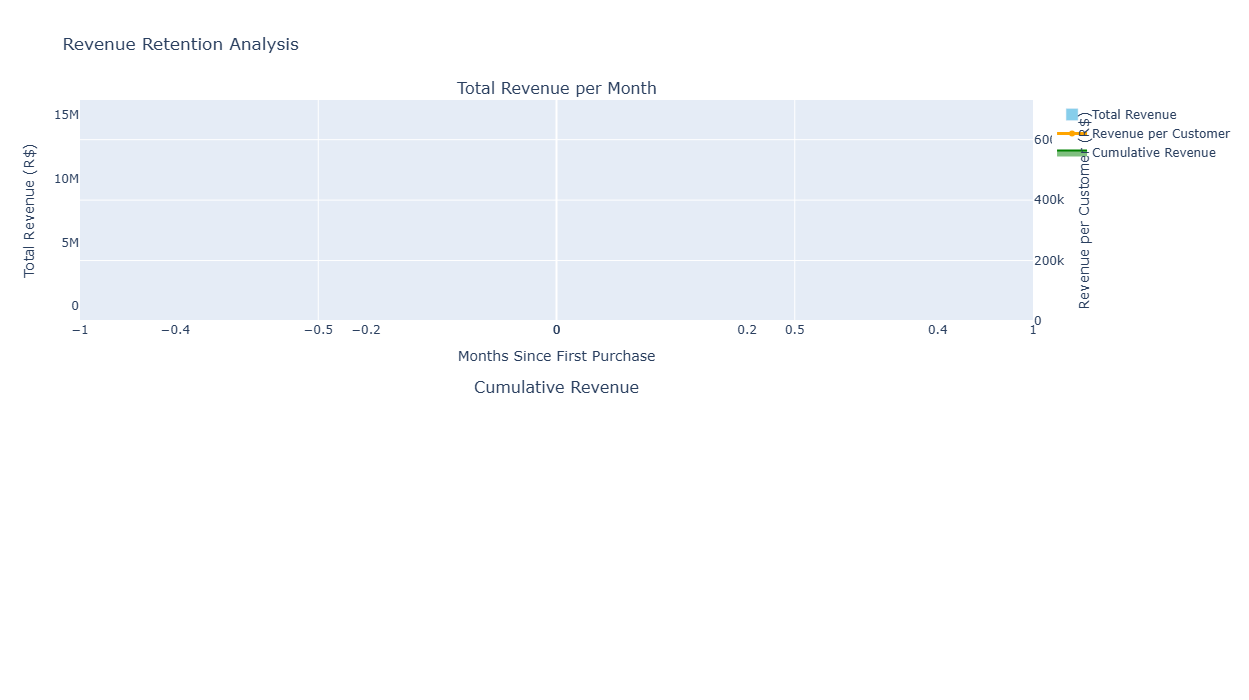

Saved: presentation/figures/revenue_retention_analysis.png

Revenue Distribution:
M0 (first purchase): 100.0% of total revenue
M1-M3 (first 3 months): 0.0% of total revenue
M4+ (after 3 months): 0.0% of total revenue
Total revenue analyzed: R$ 15,283,767
Correlation revenue per customer vs retention rate: nan


In [10]:
if len(df_cohort) > 0:
    revenue_columns = ['cohort_revenue', 'revenue_per_customer', 'cumulative_revenue']
    existing_revenue_cols = [col for col in revenue_columns if col in df_cohort.columns]
    
    if len(existing_revenue_cols) >= 2:
        revenue_by_month = df_cohort.groupby('months_since_first_purchase').agg({
            'cohort_revenue': 'sum',
            'revenue_per_customer': 'mean',
            'retention_rate': 'mean'
        }).reset_index()
        
        if 'cumulative_revenue' in df_cohort.columns:
            cumulative_revenue_by_month = df_cohort.groupby('months_since_first_purchase')['cumulative_revenue'].mean().reset_index()
            revenue_by_month = revenue_by_month.merge(cumulative_revenue_by_month, on='months_since_first_purchase')
        else:
            revenue_by_month['cumulative_revenue'] = revenue_by_month['cohort_revenue'].cumsum()
        
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Total Revenue per Month', 'Cumulative Revenue'),
            vertical_spacing=0.15
        )
        
        fig.add_trace(
            go.Bar(
                x=revenue_by_month['months_since_first_purchase'],
                y=revenue_by_month['cohort_revenue'],
                name='Total Revenue',
                marker_color='skyblue',
                text=['R$ {:,.0f}'.format(x) for x in revenue_by_month['cohort_revenue']],
                textposition='outside'
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=revenue_by_month['months_since_first_purchase'],
                y=revenue_by_month['revenue_per_customer'],
                name='Revenue per Customer',
                mode='lines+markers',
                line=dict(color='orange', width=3),
                yaxis='y2'
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=revenue_by_month['months_since_first_purchase'],
                y=revenue_by_month['cumulative_revenue'],
                name='Cumulative Revenue',
                mode='lines',
                fill='tozeroy',
                line=dict(color='green', width=2)
            ),
            row=2, col=1
        )
        
        fig.update_layout(
            title_text='Revenue Retention Analysis',
            height=700,
            showlegend=True,
            yaxis=dict(title='Total Revenue (R$)', side='left'),
            yaxis2=dict(title='Revenue per Customer (R$)', side='right', overlaying='y'),
            yaxis3=dict(title='Cumulative Revenue (R$)', side='left')
        )
        
        fig.update_xaxes(title_text='Months Since First Purchase', row=2, col=1)
        fig.show()
        
        fig.write_image("presentation/figures/revenue_retention_analysis.png", scale=2)
        print("Saved: presentation/figures/revenue_retention_analysis.png")
        
        total_revenue_all = revenue_by_month['cohort_revenue'].sum()
        
        revenue_m0 = revenue_by_month[revenue_by_month['months_since_first_purchase'] == 0]['cohort_revenue'].iloc[0] \
            if len(revenue_by_month[revenue_by_month['months_since_first_purchase'] == 0]) > 0 else 0
        
        revenue_m1_m3 = revenue_by_month[revenue_by_month['months_since_first_purchase'].between(1, 3)]['cohort_revenue'].sum()
        revenue_m4_plus = revenue_by_month[revenue_by_month['months_since_first_purchase'] >= 4]['cohort_revenue'].sum()
        
        pct_m0 = (revenue_m0 / total_revenue_all * 100) if total_revenue_all > 0 else 0
        pct_m1_m3 = (revenue_m1_m3 / total_revenue_all * 100) if total_revenue_all > 0 else 0
        pct_m4_plus = (revenue_m4_plus / total_revenue_all * 100) if total_revenue_all > 0 else 0
        
        print(f"\nRevenue Distribution:")
        print(f"M0 (first purchase): {pct_m0:.1f}% of total revenue")
        print(f"M1-M3 (first 3 months): {pct_m1_m3:.1f}% of total revenue")
        print(f"M4+ (after 3 months): {pct_m4_plus:.1f}% of total revenue")
        print(f"Total revenue analyzed: R$ {total_revenue_all:,.0f}")
        
        if 'retention_rate' in revenue_by_month.columns:
            correlation_rev_ret = revenue_by_month['revenue_per_customer'].corr(revenue_by_month['retention_rate'])
            print(f"Correlation revenue per customer vs retention rate: {correlation_rev_ret:.3f}")
            
    else:
        print(f"WARNING: Revenue columns not found. Available columns: {list(df_cohort.columns)}")
        
else:
    print("WARNING: Empty DataFrame.")

## 10. LTV BY COHORT

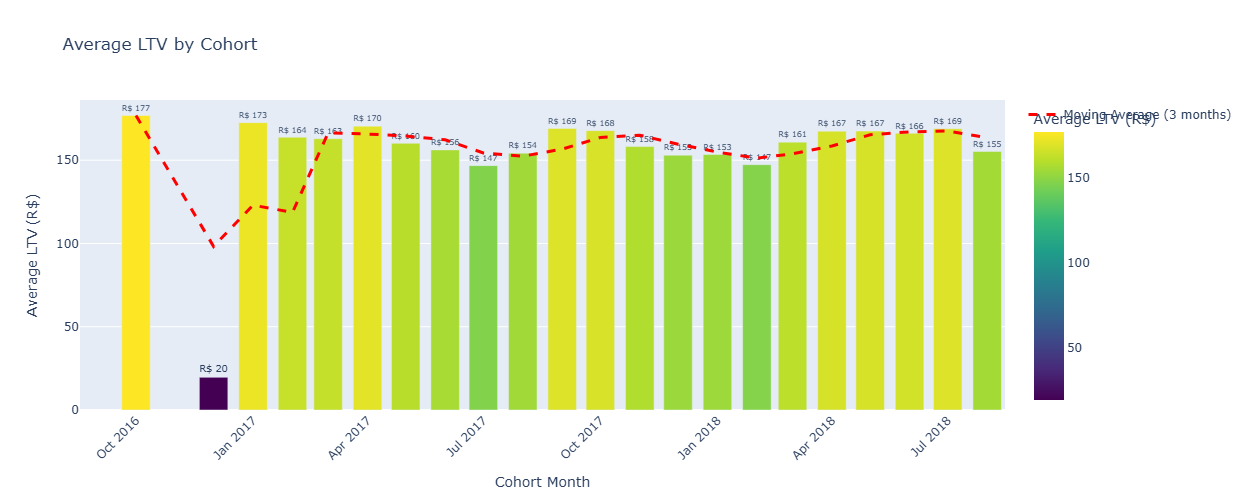

Saved: presentation/figures/ltv_by_cohort.png

LTV Analysis:
Average LTV across all cohorts: R$ 155.38
Best cohort LTV: R$ 176.84
Worst cohort LTV: R$ 19.62
Range: R$ 157.22 (9.0x difference)
Correlation cohort_size vs LTV: 0.300


In [11]:
if len(df_cohort) > 0:
    if 'cumulative_revenue' in df_cohort.columns:
        ltv_by_cohort = []
        
        for cohort in df_cohort['cohort_month'].unique():
            cohort_data = df_cohort[df_cohort['cohort_month'] == cohort]
            max_cumulative_rev = cohort_data['cumulative_revenue'].max()
            
            cohort_size_data = cohort_data[cohort_data['months_since_first_purchase'] == 0]['cohort_size']
            if len(cohort_size_data) > 0:
                cohort_size = cohort_size_data.iloc[0]
            else:
                cohort_size = 0
            
            if cohort_size > 0:
                avg_ltv = max_cumulative_rev / cohort_size
                
                m3_retention_data = cohort_data[cohort_data['months_since_first_purchase'] == 3]['retention_rate']
                m3_retention = m3_retention_data.iloc[0] if len(m3_retention_data) > 0 else None
                
                ltv_by_cohort.append({
                    'cohort_month': cohort,
                    'cohort_size': cohort_size,
                    'total_cumulative_revenue': max_cumulative_rev,
                    'avg_ltv': avg_ltv,
                    'm3_retention': m3_retention
                })
        
        if ltv_by_cohort:
            ltv_df = pd.DataFrame(ltv_by_cohort)
            
            fig = px.bar(
                ltv_df.sort_values('cohort_month'),
                x='cohort_month',
                y='avg_ltv',
                title='Average LTV by Cohort',
                labels={'cohort_month': 'Cohort Month', 'avg_ltv': 'Average LTV (R$)'},
                text='avg_ltv',
                color='avg_ltv',
                color_continuous_scale='Viridis'
            )
            
            fig.update_traces(texttemplate='R$ %{text:.0f}', textposition='outside')
            
            fig.add_trace(
                go.Scatter(
                    x=ltv_df.sort_values('cohort_month')['cohort_month'],
                    y=ltv_df.sort_values('cohort_month')['avg_ltv'].rolling(window=3, min_periods=1).mean(),
                    mode='lines',
                    name='Moving Average (3 months)',
                    line=dict(color='red', width=3, dash='dash')
                )
            )
            
            fig.update_layout(height=500, xaxis_tickangle=-45, showlegend=True)
            fig.show()
            
            fig.write_image("presentation/figures/ltv_by_cohort.png", scale=2)
            print("Saved: presentation/figures/ltv_by_cohort.png")
            
            avg_ltv_all = ltv_df['avg_ltv'].mean()
            max_ltv = ltv_df['avg_ltv'].max()
            min_ltv = ltv_df['avg_ltv'].min()
            ltv_range = max_ltv - min_ltv
            
            print(f"\nLTV Analysis:")
            print(f"Average LTV across all cohorts: R$ {avg_ltv_all:.2f}")
            print(f"Best cohort LTV: R$ {max_ltv:.2f}")
            print(f"Worst cohort LTV: R$ {min_ltv:.2f}")
            print(f"Range: R$ {ltv_range:.2f} ({max_ltv/min_ltv:.1f}x difference)")
            
            correlation_size_ltv = ltv_df['cohort_size'].corr(ltv_df['avg_ltv'])
            print(f"Correlation cohort_size vs LTV: {correlation_size_ltv:.3f}")
            
            ltv_df_valid = ltv_df[ltv_df['m3_retention'].notna()]
            if len(ltv_df_valid) > 5:
                correlation_retention_ltv = ltv_df_valid['m3_retention'].corr(ltv_df_valid['avg_ltv'])
                print(f"Correlation M3 retention vs LTV: {correlation_retention_ltv:.3f}")
            
        else:
            print("WARNING: Could not calculate LTV.")
            
    else:
        print("WARNING: 'cumulative_revenue' column not found for LTV calculation.")
        
else:
    print("WARNING: Empty DataFrame.")

## 11. RETENTION IMPROVEMENT SIMULATION

In [12]:
if len(df_cohort) > 0:
    m1_data = df_cohort[df_cohort['months_since_first_purchase'] == 1]
    m3_data = df_cohort[df_cohort['months_since_first_purchase'] == 3]
    
    if len(m1_data) > 0 and len(m3_data) > 0:
        current_m1_retention = m1_data['retention_rate'].mean()
        current_m3_retention = m3_data['retention_rate'].mean()
        
        df_cohort_m0 = df_cohort[df_cohort['months_since_first_purchase'] == 0]
        if len(df_cohort_m0) > 0:
            avg_cohort_size = df_cohort_m0['cohort_size'].mean()
        else:
            avg_cohort_size = 1000
        
        avg_revenue_per_customer = 500
        
        simulation_scenarios = []
        
        new_m1_retention = min(current_m1_retention + 0.05, 1.0)
        additional_retention_m1 = new_m1_retention - current_m1_retention
        additional_customers_m1 = avg_cohort_size * additional_retention_m1
        additional_revenue_m1 = additional_customers_m1 * avg_revenue_per_customer
        campaign_cost_m1 = avg_cohort_size * 20
        roi_m1 = (additional_revenue_m1 - campaign_cost_m1) / campaign_cost_m1 * 100 if campaign_cost_m1 > 0 else 0
        
        simulation_scenarios.append({
            'Scenario': 'Improve M1 Retention +5%',
            'Retention Increase': '+5.0%',
            'Customers Retained': int(additional_customers_m1),
            'Additional Revenue (R$)': additional_revenue_m1,
            'Campaign Cost (R$)': campaign_cost_m1,
            'ROI': roi_m1
        })
        
        new_m3_retention = min(current_m3_retention + 0.10, 1.0)
        additional_retention_m3 = new_m3_retention - current_m3_retention
        additional_customers_m3 = avg_cohort_size * additional_retention_m3
        additional_revenue_m3 = additional_customers_m3 * avg_revenue_per_customer * 2
        campaign_cost_m3 = avg_cohort_size * 30
        roi_m3 = (additional_revenue_m3 - campaign_cost_m3) / campaign_cost_m3 * 100 if campaign_cost_m3 > 0 else 0
        
        simulation_scenarios.append({
            'Scenario': 'Improve M3 Retention +10%',
            'Retention Increase': '+10.0%',
            'Customers Retained': int(additional_customers_m3),
            'Additional Revenue (R$)': additional_revenue_m3,
            'Campaign Cost (R$)': campaign_cost_m3,
            'ROI': roi_m3
        })
        
        simulation_df = pd.DataFrame(simulation_scenarios)
        
        fig = px.bar(
            simulation_df,
            x='Scenario',
            y='ROI',
            title='ROI of Different Retention Improvement Scenarios',
            labels={'Scenario': 'Scenario', 'ROI': 'ROI (%)'},
            text='ROI',
            color='ROI',
            color_continuous_scale='RdYlGn'
        )
        
        fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
        fig.update_layout(height=400, showlegend=False)
        fig.show()
        
        fig.write_image("presentation/figures/retention_roi_simulation.png", scale=2)
        print("Saved: presentation/figures/retention_roi_simulation.png")
        
        best_scenario_idx = simulation_df['ROI'].idxmax()
        best_scenario = simulation_df.loc[best_scenario_idx]
        
        print(f"\nSimulation Results:")
        print(f"Current M1 retention: {current_m1_retention:.1%}")
        print(f"Current M3 retention: {current_m3_retention:.1%}")
        print(f"\nBest scenario: {best_scenario['Scenario']}")
        print(f"Expected ROI: {best_scenario['ROI']:.1f}%")
        print(f"Additional customers retained: {best_scenario['Customers Retained']:,}")
        print(f"Additional revenue: R$ {best_scenario['Additional Revenue (R$)']:,.0f}")
        
    else:
        print("WARNING: Insufficient retention data for simulation.")
        
else:
    print("WARNING: Empty DataFrame.")

## 12. COHORT PERFORMANCE RECOMMENDATIONS

In [13]:
if len(df_cohort) > 0:
    df_m3 = df_cohort[df_cohort['months_since_first_purchase'] == 3]
    
    if len(df_m3) > 0:
        df_m3 = df_m3.copy()
        df_m3['retention_rank'] = df_m3['retention_rate'].rank(pct=True)
        
        high_performers = df_m3[df_m3['retention_rank'] >= 0.7]
        medium_performers = df_m3[(df_m3['retention_rank'] >= 0.3) & (df_m3['retention_rank'] < 0.7)]
        low_performers = df_m3[df_m3['retention_rank'] < 0.3]
        
        recommendations_data = []
        
        for group_name, group_data in [
            ('High Performers', high_performers),
            ('Medium Performers', medium_performers),
            ('Low Performers', low_performers)
        ]:
            if len(group_data) > 0:
                avg_m3_retention = group_data['retention_rate'].mean() * 100
                total_cohorts = len(group_data)
                total_customers = group_data['cohort_size'].sum()
                
                if group_name == 'High Performers':
                    action = 'Maintain engagement, premium loyalty programs, referrals'
                    channel = 'Personalized email, App push, Ambassador program'
                elif group_name == 'Medium Performers':
                    action = 'Incentive campaigns, upsell, cross-sell, improved onboarding'
                    channel = 'Email marketing, SMS, Push notifications'
                else:
                    action = 'Aggressive win-back, satisfaction survey, personalized offers, onboarding review'
                    channel = 'Win-back email, Phone, NPS survey, Direct offers'
                
                recommendations_data.append({
                    'Cohort Group': group_name,
                    'Cohort Count': total_cohorts,
                    'Total Customers': f'{total_customers:,}',
                    'Avg M3 Retention': f'{avg_m3_retention:.1f}%',
                    'Action': action,
                    'Channel': channel
                })
        
        if recommendations_data:
            recommendations_df = pd.DataFrame(recommendations_data)
            
            print("COHORT PERFORMANCE RECOMMENDATIONS:")
            print("="*60)
            print(recommendations_df)
            
            if len(low_performers) > 0:
                low_performers_export = low_performers[['cohort_month', 'cohort_size', 'retention_rate']].copy()
                low_performers_export['retention_rate'] = low_performers_export['retention_rate'].apply(lambda x: f'{x:.1%}')
                low_performers_export.to_csv('low_performing_cohorts.csv', index=False)
                print(f"\nLow performers list exported to 'low_performing_cohorts.csv' ({len(low_performers)} cohorts)")
            
            print("\nSUMMARY OF GROUPS:")
            for _, row in recommendations_df.iterrows():
                print(f"\n{row['Cohort Group']}:")
                print(f"  Cohorts: {row['Cohort Count']}")
                print(f"  Customers: {row['Total Customers']}")
                print(f"  M3 Retention: {row['Avg M3 Retention']}")
                print(f"  Primary Action: {row['Action']}")
                
        else:
            print("WARNING: Could not create recommendations.")
            
    else:
        print("WARNING: No data for months_since_first_purchase = 3")
        
else:
    print("WARNING: Empty DataFrame.")

## 13. KEY INSIGHTS AND EXECUTIVE SUMMARY

In [14]:
if len(df_cohort) > 0:
    if 1 in df_cohort['months_since_first_purchase'].values:
        m1_data = df_cohort[df_cohort['months_since_first_purchase'] == 1]
        if len(m1_data) > 0:
            avg_m1_retention = m1_data['retention_rate'].mean() * 100
            m1_loss = 100 - avg_m1_retention
        else:
            avg_m1_retention = m1_loss = None
    else:
        avg_m1_retention = m1_loss = None
    
    if 3 in df_cohort['months_since_first_purchase'].values:
        m3_data = df_cohort[df_cohort['months_since_first_purchase'] == 3]
        if len(m3_data) > 0:
            avg_m3_retention = m3_data['retention_rate'].mean() * 100
        else:
            avg_m3_retention = None
    else:
        avg_m3_retention = None
    
    df_cohort_m0 = df_cohort[df_cohort['months_since_first_purchase'] == 0]
    if len(df_cohort_m0) > 0:
        total_customers = df_cohort_m0['cohort_size'].sum()
    else:
        total_customers = 0
    
    print("=" * 60)
    print("COHORT RETENTION ANALYSIS - EXECUTIVE SUMMARY")
    print("=" * 60)
    print(f"Total Cohorts Analyzed: {df_cohort['cohort_month'].nunique()}")
    print(f"Total Customers: {total_customers:,}")
    
    if avg_m1_retention:
        print(f"Average M1 Retention: {avg_m1_retention:.2f}%")
    
    if avg_m3_retention:
        print(f"Average M3 Retention: {avg_m3_retention:.2f}%")
    
    summary_text = "\nKEY INSIGHTS:\n\n"
    
    if avg_m1_retention:
        summary_text += f"1. Initial Drop-off: {m1_loss:.1f}% of customers leave in the first month\n"
    
    if avg_m1_retention and avg_m3_retention:
        m1_m3_loss = avg_m1_retention - avg_m3_retention
        summary_text += f"2. Critical Period: Additional {m1_m3_loss:.1f}% drop between M1 and M3\n"
    
    summary_text += f"3. Intervention Window: Days 30-45 are critical for re-engagement\n"
    summary_text += f"4. Customer Value: Retained customers generate significantly more revenue\n"
    summary_text += f"5. Cohort Variation: Performance varies widely between cohorts\n"
    
    print(summary_text)
    
    print("\nRECOMMENDATIONS:")
    print("1. Implement onboarding campaign (days 0-30)")
    print("2. Automatic win-back at day 45 (before M2 drop-off)")
    print("3. Loyalty program for M3+ active customers")
    print("4. Satisfaction survey at M1 for low-performing cohorts")
    print("5. Personalized offers based on customer behavior")
    
    print("\nEXPORTED VISUALIZATIONS:")
    print("- cohort_size_monthly.png")
    print("- cohort_retention_heatmap.png")
    print("- retention_curve_average.png")
    print("- retention_curves_recent.png")
    print("- dropoff_analysis.png")
    print("- best_worst_cohorts.png")
    print("- revenue_retention_analysis.png")
    print("- ltv_by_cohort.png")
    print("- retention_roi_simulation.png")
    
    print("\nAll visualizations saved in 'presentation/figures/' folder")
    
else:
    print("WARNING: Could not generate summary.")

print("\n" + "="*60)
print("COHORT RETENTION ANALYSIS COMPLETED")
print("="*60)

COHORT RETENTION ANALYSIS - EXECUTIVE SUMMARY
Total Cohorts Analyzed: 23
Total Customers: 95,419

KEY INSIGHTS:

3. Intervention Window: Days 30-45 are critical for re-engagement
4. Customer Value: Retained customers generate significantly more revenue
5. Cohort Variation: Performance varies widely between cohorts


RECOMMENDATIONS:
1. Implement onboarding campaign (days 0-30)
2. Automatic win-back at day 45 (before M2 drop-off)
3. Loyalty program for M3+ active customers
4. Satisfaction survey at M1 for low-performing cohorts
5. Personalized offers based on customer behavior

EXPORTED VISUALIZATIONS:
- cohort_size_monthly.png
- cohort_retention_heatmap.png
- retention_curve_average.png
- retention_curves_recent.png
- dropoff_analysis.png
- best_worst_cohorts.png
- revenue_retention_analysis.png
- ltv_by_cohort.png
- retention_roi_simulation.png

All visualizations saved in 'presentation/figures/' folder

COHORT RETENTION ANALYSIS COMPLETED
